Time taken: 8.45
Time taken: 8.35


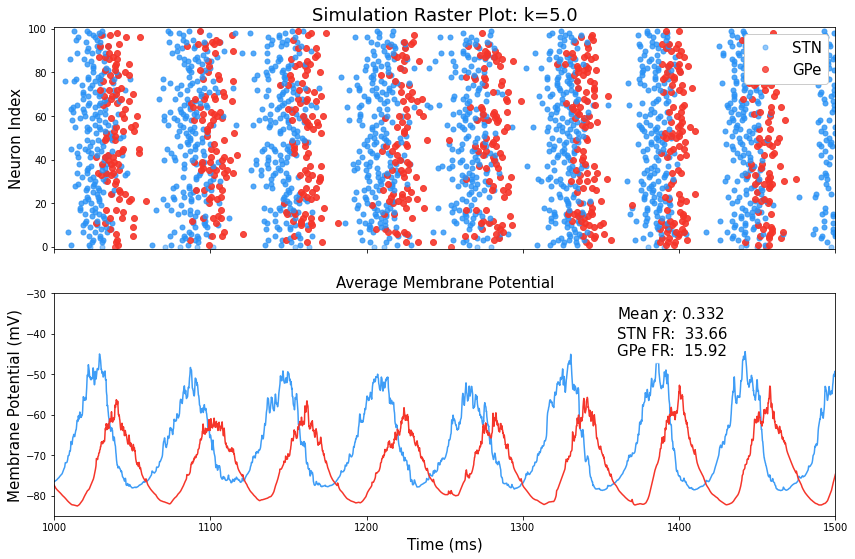

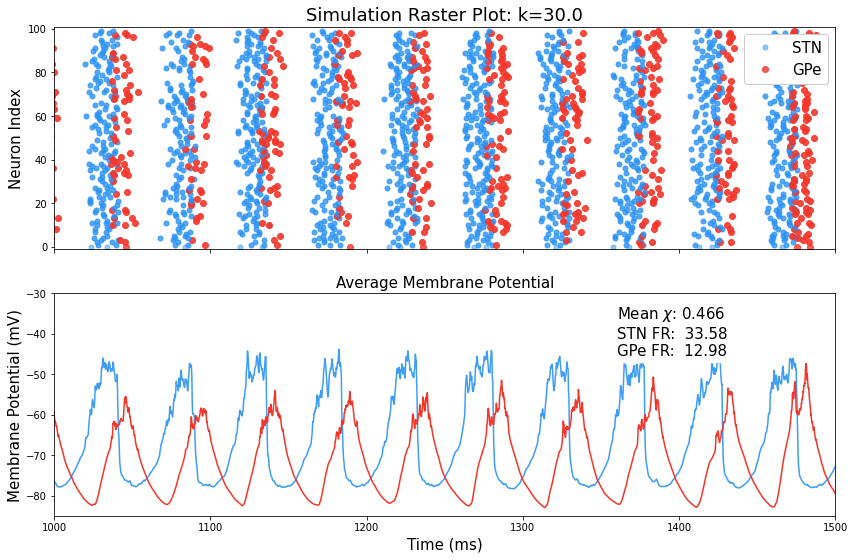

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time as time

from SimulationControl import SimControl

ps = {"Spatial": 0.01,
      "Small_world":0.01 ,
      "Scale_free": 1, 
      "SBlock": 1-0.01,
      "Regular": 0,}

for SimulationNetworkToUse in ["Regular"]:
    for ParticularKValue in [5,30]:
        SimCon = SimControl()
        
        
        SimCon.params["k"] = ParticularKValue
        SimCon.params["Network_type"] = SimulationNetworkToUse
        
        
        SimCon.params["Notebook"] = 1 #1 is to save the firing data, 2 is to save the network data and firing data, 0 is for simulating on cluster
        SimCon.params["simtime"] = 1500
        SimCon.params["h"] = 0.1
        SimCon.params["n"] = 100
        SimCon.params["p"] = ps[SimCon.params["Network_type"]]

        t0 = time.time()
        res = os.system(SimCon.Generate_Command())
        t1 = time.time()

        print(f"Time taken: {t1-t0:.2f}")

        assert res==0

        data = np.load("NotebookData.npy",allow_pickle=True).item()
        netdat = np.load("NotebookNetworkData.npy",allow_pickle=True).item()

        STN = data["STN"]
        GPe = data["GPe"]
        data_dict = data["data"]

        STG_list = netdat["STG_list"]
        GTS_list = netdat["GTS_list"]
        GTG_list = netdat["GTG_list"]
        graph_measures = netdat["graph_measures"]

        #Make sure the correct data is being loaded 
        for key in SimCon.params:
            if key not in ['weight', 'GSweight', 'GGweight']: # these params dont count
                assert SimCon.params[key] == data_dict[key]

        dt = SimCon.params["h"]
        simtime = SimCon.params["simtime"]

        def get_spike_trains(pop):
            main_lis = []
            for sp in pop.spiketrains:
                s_lis = [ float(i) for i in sp] 
                main_lis.append(np.array(s_lis))

            return main_lis

        low_cutoff = int(500/dt) #number of segments corresponding to first 500ms

        SLFP = np.array(STN.filter(name='soma(0.5).v')[0]).mean(axis=1)#(axis=1)
        GLFP = np.array(GPe.filter(name='soma(0.5).v')[0]).mean(axis=1)


        packed_dat = [{"SLFP": SLFP,"GLFP": GLFP,
                       "STrain":get_spike_trains(STN),
                       "GTrain":get_spike_trains(GPe),
                       "Sync":np.sqrt(data_dict['STN synchrony']*data_dict['GPe synchrony']) ,
                      "SMean":data_dict["SMean"],
                       "GMean":data_dict["GMean"],
                      }]
        #loc = 'dataOct21\\'
        netname = data_dict['Network_type']
        #name = f'S_{netname}_{n}_{data_dict["k"]}_{data_dict["p"]:5f}_{data_dict["recip"]:.5f}.npy'
        #np.save(loc+name,packed_dat)
        recovered_dat = packed_dat[0] #np.load(loc+name,allow_pickle=True)[0]


        cols = '#2A92F5'
        colg = '#F5352A'


        k = data_dict["k"]
        netlab = {'Regular':'k-Regular',  'Small_world': 'Small World','Spatial':'Nearest Neighbour',
                  'Scale_free': 'Preferential Attachment','SBlock': 'Stochastic Block'}

        SLFP = recovered_dat["SLFP"]
        GLFP = recovered_dat["GLFP"]

        STrain = recovered_dat["STrain"]
        GTrain = recovered_dat["GTrain"]

        sync = float(recovered_dat["Sync"])
        textstr = r'Mean $\chi$: '+ f'{sync:>3.3f}' + f"\nSTN FR: {data_dict['SMean']:>6.2f} \nGPe FR: {data_dict['GMean']:>6.2f} " 

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white')

        # place a text box in upper left in axes coords

        infigfontsize = 15
        titlefontsize = 18

        ilim = 100

        x_axis = np.linspace(0,simtime,len(GLFP))

        fig,ax = plt.subplots(2,1,figsize=[14,9],sharex=True)
        #fig.suptitle(params["Network_type"])

        for i, train in enumerate(zip(STrain,GTrain)):
            train1 = train[0]
            train2 = train[1]
            if i>ilim:
                break
            if i==0:
                ax[0].plot(train1, i*np.ones(len(train1)), 'o', color = cols,markersize=5, alpha=0.5, label='STN')
                ax[0].plot(train2, i*np.ones(len(train2)), 'o', color = colg,markersize=6, alpha=0.8, label='GPe')
            else:
                ax[0].plot(train1, i*np.ones(len(train1)), 'o', color = cols,markersize=5, alpha=0.8)
                ax[0].plot(train2, i*np.ones(len(train2)), 'o', color = colg,markersize=6, alpha=0.9)


        #f'{netlab[data_dict["Network_type"]]} Network'
        ax[0].set_title(f'Simulation Raster Plot: k={k}',fontsize=titlefontsize)
        ax[0].set_ylabel("Neuron Index",fontsize=infigfontsize)
        ax[0].set_xlim(1000,1500)
        ax[0].set_ylim(-1,ilim+1)
        ax[0].legend(fontsize=infigfontsize,loc='upper right',framealpha=1)
        #ax[0].legend(fontsize=16,framealpha=1,shadow = True,borderpad=0.8,loc='upper right')

        ax[1].plot(x_axis, SLFP, label = 'STN',color = cols, alpha=0.9)
        ax[1].plot(x_axis, GLFP, label = 'GPe',color = colg, alpha=1)
        ax[1].set_title('Average Membrane Potential',fontsize=infigfontsize)
        ax[1].set_ylabel("Membrane Potential (mV)",fontsize=infigfontsize)
        ax[1].set_xlabel("Time (ms)",fontsize=infigfontsize)
        ax[1].set(ylim=[-85,-30,])
        ax[1].text(0.72, 0.95, textstr, transform=ax[1].transAxes, color='k', fontsize=infigfontsize, verticalalignment='top', bbox=props)
        # for i,trains in enumerate(GTrain):
        #     ax.plot(trains, i*np.ones(len(trains)), 'o', color = 'r',markersize=5, alpha=0.8)

        np.save("NewAmalgData\\"+f"{netname}_{int(k)}.npy",recovered_dat)   

In [21]:
dat2={}

for S in ["Spatial","Small_world","Scale_free", "SBlock","Regular"]:
    for K in [5,30]:
        dat2[(S,K)] = np.load("NewAmalgData\\"+f"{S}_{int(K)}.npy",allow_pickle=True).item(0)

        

In [22]:
np.save("LFPsMarch.npy",dat2)

In [8]:
net="Spatial"
np.load("NewAmalgData\\"+f"{net}_{int(5)}.npy",allow_pickle=True) 

array({'SLFP': array([-61.32192088, -62.05697222, -62.75611641, ..., -72.48183645,
       -72.20033272, -71.81330431]), 'GLFP': array([-61.26531556, -61.44373326, -61.63942642, ..., -71.71544091,
       -71.90803117, -72.09482684]), 'STrain': [array([  21.8,   66. ,   77.8,  124.5,  130.9,  139.7,  198. ,  205.5,
        212.5,  259. ,  266.1,  274.1,  322.9,  339.8,  349.2,  358.3,
        368.7,  378.5,  395.1,  403.6,  411.9,  455.8,  498.2,  506.8,
        563.7,  569.9,  600.7,  610. ,  651.1,  659.2,  668.9,  681.8,
        689.3,  746.7,  753.3,  775.5,  828.6,  840. ,  898.1,  904.6,
        913.2,  929. ,  938.2,  988.3,  995.4, 1004.7, 1055.3, 1062.2,
       1106.6, 1112.7, 1120.8, 1167.9, 1181.2, 1231.6, 1247.1, 1298.7,
       1312.4, 1344.1, 1354.3, 1373.4, 1415.5, 1423.2, 1477.9, 1489.9,
       1497.5]), array([   9.1,   18.4,   65. ,   73.9,  137.4,  178.8,  189.1,  240.9,
        249.7,  257.1,  314. ,  321.9,  371.5,  378.5,  424.4,  437.2,
        493.5,  503.1,  553.6